In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from math import sqrt
kfold=KFold(n_splits=5, random_state=0)
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

Importing the cleaned dataset, which joins the election results with census data

In [141]:
auburn = pd.read_csv(r"C:\Users\test\Documents\auburnelections\modelingdataset.csv")
auburn = auburn.drop(["tract", "Precinct", "Wales", "Backus"], axis = 1)
auburn = auburn.replace(np.nan, 0)

In [101]:
doublets = []
for i in auburn.columns:
    if i[-2:] == ".1":
        doublets.append(i)

In [118]:
try:
    auburn = auburn.drop(doublets, axis =1 )
except ValueError:
    pass

# Classification Model

This first model determines the differences between districts that Largo Wales and Nancy Backus won. It's a simple classification model, called a Support Vector Machine, which attempts to draw a multi-dimensional shape between these types of data, if we think of them all as being on some sort of three dimensional graph.

In [105]:
def logreg(X, y, params):
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, train_size=.7)
    parameters = {"C":params}
    logreg = LogisticRegression(max_iter = 1000)
    model = GridSearchCV(logreg, parameters, cv = kfold, scoring = "accuracy")
    model.fit(X_train, y_train)
    bestmd = model.best_params_["C"]
    lr = LogisticRegression(C = bestmd).fit(X_train, y_train)
    print("Accuracy Score on training data logistic regression model: {}".format(lr.score(X_train, y_train)))
    print("Accuracy Score on test data logistic regression model: {}".format(lr.score(X_test, y_test)))
    return lr.score(X_train, y_train), lr.score(X_test, y_test), lr.coef_

In [122]:
train, test, feat = logreg(x, y, [0.0001, 0.001, 0.01, 0.1, 1, 10])

C:\Users\test\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy Score on training data logistic regression model: 0.7592592592592593
Accuracy Score on test data logistic regression model: 0.7916666666666666


In [123]:
feat = feat[0]

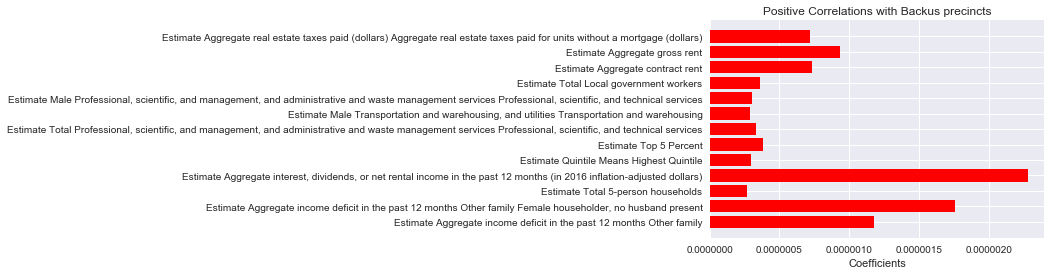

In [112]:
features=x.columns[feat >  0.00000025]
coefficients=list(feat[feat >  0.00000025])
n_features = x.columns[feat >  0.00000025].values.shape[0]
plt.barh(range(n_features), coefficients, align="center", color="red")
plt.yticks(np.arange(n_features), features)
plt.title("Positive Correlations with Backus precincts")
plt.xlabel("Coefficients")

(array([ -3.00000000e-06,  -2.50000000e-06,  -2.00000000e-06,
         -1.50000000e-06,  -1.00000000e-06,  -5.00000000e-07,
          0.00000000e+00]), <a list of 7 Text xticklabel objects>)

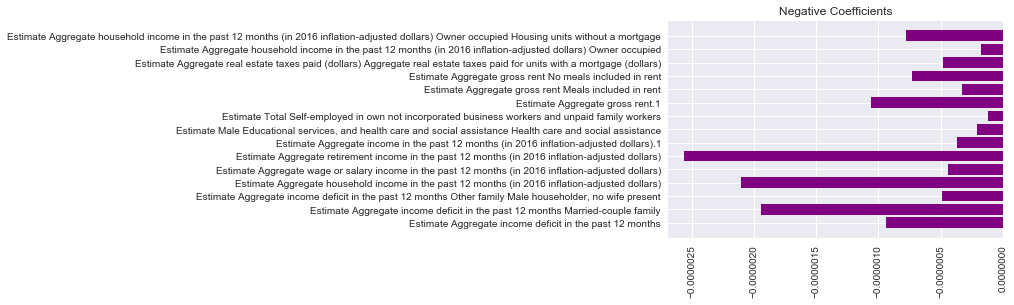

In [124]:
features=x.columns[feat <  -0.0000001]
coefficients=list(feat[feat <  -0.0000001])
n_features = x.columns[feat <  -0.0000001].values.shape[0]
plt.barh(range(n_features), coefficients, align="center", color="purple")
plt.yticks(np.arange(n_features), features)
plt.title("Negative Coefficients")
plt.xticks(rotation = "vertical")

#  Regression Model for Backus Margin

What factors correlate strongly with Nancy Backus' win margin in specific precincts? This model answers those questions. 

In [129]:
print(auburn.MayorMargin.mean())
y = auburn["MayorMargin"]
x = auburn.drop(["Unnamed: 3343", "MayorMargin", "turnout"], axis =1 )

AttributeError: 'DataFrame' object has no attribute 'MayorMargin'

In [133]:

x = x.drop("MayorMargin", axis =1 )

In [130]:
def gbr(X, y, max_depth):
    X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=0, train_size=.7)
    parameters={"max_depth":max_depth}
    gb=GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, random_state=0, loss='ls')
    model=GridSearchCV(gb, parameters, cv=kfold, scoring="neg_mean_squared_error", n_jobs=3)
    model.fit(X_train, y_train)
    bestmd=model.best_params_["max_depth"]
    gb=GradientBoostingRegressor(n_estimators=200,max_depth=bestmd, learning_rate=0.1, random_state=0, loss='ls').fit(X_train, y_train)
    y_predtrain=gb.predict(X_train)
    print("Root Mean Squared Error on train data: {}".format(sqrt(mean_squared_error(y_train, y_predtrain))))
    y_pred=gb.predict(X_test)
    print("Root Mean Squared Error on test data: {}".format(sqrt(mean_squared_error(y_test, y_pred))))
    print("The parameters are: {}".format(bestmd))
    return sqrt(mean_squared_error(y_train, y_predtrain)),sqrt(mean_squared_error(y_test, y_pred)), gb.feature_importances_

In [134]:
train, test, gb = gbr(x, y, [1,2,3,4,5,6,7,8,9,10])

C:\Users\test\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Root Mean Squared Error on train data: 8.781922123401046
Root Mean Squared Error on test data: 20.022915423709705
The parameters are: 1


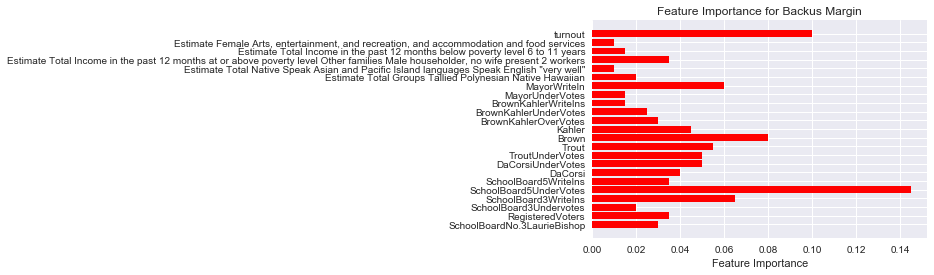

In [135]:
features=x.columns[gb > 0.005]
coefficients=list(gb[gb > 0.005])
n_features = x.columns[gb > 0.005].values.shape[0]
plt.barh(range(n_features), coefficients, align="center", color="red")
plt.yticks(np.arange(n_features), features)
plt.title("Feature Importance for Backus Margin")
plt.xlabel("Feature Importance")

In [138]:
auburn.turnout.mean()

0.31163865285897435

# Regression Model for Turnout

What factors drive turnout in Auburn's precincts?

In [59]:
y = auburn["turnout"]
auburn = auburn.drop("turnout", axis =1 )
x = auburn

In [61]:
def rfr(X, y, mdparams, mlnparams, mslparams):
    X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=0, train_size=.75)
    parameters={"max_depth":mdparams, "max_leaf_nodes":mlnparams, "min_samples_leaf": mslparams}
    rf=RandomForestRegressor(n_estimators=50)
    model=GridSearchCV(rf, parameters, cv=kfold, scoring="neg_mean_squared_error", n_jobs=3)
    model.fit(X_train, y_train)
    bestmd=model.best_params_["max_depth"]
    bestmln=model.best_params_["max_leaf_nodes"]
    bestmsl=model.best_params_["min_samples_leaf"]
    r=RandomForestRegressor(n_estimators=200,max_depth=bestmd, max_leaf_nodes=bestmln, min_samples_leaf=bestmsl).fit(X_train, y_train)
    y_predtrain=r.predict(X_train)
    print("Root Mean Squared Error on train data: {}".format(sqrt(mean_squared_error(y_train, y_predtrain))))
    y_pred=r.predict(X_test)
    print("Root Mean Squared Error on test data: {}".format(sqrt(mean_squared_error(y_test, y_pred))))
    print("The parameters are: {}".format([bestmd, bestmln, bestmsl]))
    return sqrt(mean_squared_error(y_train, y_predtrain)), sqrt(mean_squared_error(y_test, y_pred)), r.feature_importances_

In [62]:
train, test, sig = rfr(x, y, [8,10, 11,12,13,14,15,16,17, 18], [3,4,5,6,7,8,9], [5,8,11,14,17,20])

C:\Users\test\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Root Mean Squared Error on train data: 0.06217863930952916
Root Mean Squared Error on test data: 0.057280714345938295
The parameters are: [12, 5, 5]


([<matplotlib.axis.YTick at 0x1b54441b8d0>,
 <a list of 15 Text yticklabel objects>)

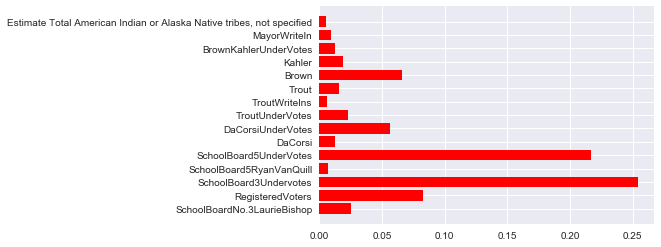

In [65]:
features=x.columns[sig > 0.005]
coefficients=list(sig[sig > 0.005])
n_features = x.columns[sig > 0.005].values.shape[0]
plt.barh(range(n_features), coefficients, align="center", color="red")
plt.yticks(np.arange(n_features), features)

In [35]:
auburn.columns[auburn.columns.str.contains("UnderVotes")]

Index(['SchoolBoard5UnderVotes', 'DaCorsiUnderVotes', 'TroutUnderVotes',
       'BrownKahlerUnderVotes', 'MayorUnderVotes'],
      dtype='object')

In [48]:
uv = auburn[['SchoolBoard5UnderVotes', "SchoolBoard3Undervotes", 'DaCorsiUnderVotes', 'TroutUnderVotes',
       'BrownKahlerUnderVotes', 'MayorUnderVotes']]
uv.columns = ["School Board 5 UnderVotes",  "School Board 3 UnderVotes", 'DaCorsi UnderVotes', 'Trout UnderVotes',
       'Brown and Kahler UnderVotes', 'Mayor UnderVotes']

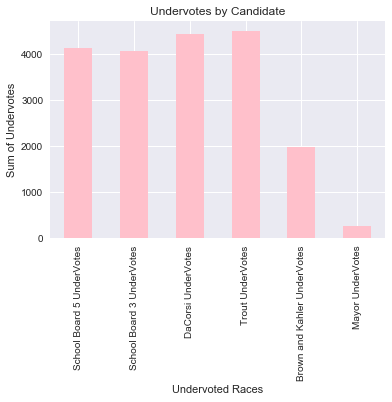

In [50]:
uv.sum(axis =0).plot.bar(color = "pink")
plt.title("Undervotes by Candidate")
plt.ylabel("Sum of Undervotes")
plt.xlabel("Undervoted Races")

In [140]:
auburn.columns[auburn.columns.str.contains("UnderVotes")]

Index(['SchoolBoard5UnderVotes', 'DaCorsiUnderVotes', 'TroutUnderVotes',
       'BrownKahlerUnderVotes', 'MayorUnderVotes'],
      dtype='object')

In [152]:
uv =  auburn[["SchoolBoard5UnderVotes", "TroutUnderVotes", "DaCorsiUnderVotes", "logreg"]]

In [157]:
uv["avg"] = (uv["SchoolBoard5UnderVotes"]+ uv["TroutUnderVotes"] + uv["DaCorsiUnderVotes"])/3

C:\Users\test\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [160]:
backus = uv[uv.logreg == 1.0]

In [161]:
backus.avg.mean()

54.58333333333332

In [163]:
wales = uv[uv.logreg == 0.0]
wales.avg.mean()

59.74074074074073

In [165]:
wales

,SchoolBoard5UnderVotes,TroutUnderVotes,DaCorsiUnderVotes,logreg,avg
6,101.0,134.0,133.0,0.0,122.666667
8,0.0,68.0,69.0,0.0,45.666667
20,59.0,52.0,55.0,0.0,55.333333
23,54.0,41.0,54.0,0.0,49.666667
28,56.0,50.0,50.0,0.0,52.000000
30,115.0,119.0,113.0,0.0,115.666667
31,115.0,119.0,113.0,0.0,115.666667
42,62.0,55.0,59.0,0.0,58.666667
43,62.0,55.0,59.0,0.0,58.666667
46,9.0,11.0,10.0,0.0,10.000000
